Some portions of this code uitilize the EAST detector model tutorial from PyImageSearch.

Original tutorial: "OpenCV Text Detection (EAST text detector)" by Adrian Rosebrock

Available at: https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/



This notebook has code to convert a pre-trained EAST model to TFLite.


The EAST pipeline is capable of predicting words and lines of text at arbitrary orientations on 720p images, and furthermore, can run at 13 FPS, according to the authors.

EAST was proposed in An Efficient and Accurate Scene Text Detector.

## Setup

Acknowledgments:
This project utilizes the EAST algorithm methodologies from the following GitHub repositories:
1. OpenCV Text Detection by gifflet: https://github.com/gifflet/opencv-text-detection
2. Adventures in TensorFlow Lite (EAST_TFLite notebook) by Sayak Paul:
https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/EAST_TFLite.ipynb

In [54]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [55]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
from imutils import paths
import numpy as np
import time
import cv2
import os

## Cloning into an existing GitHub repository with the OpenCV text detection EAST algorithm

In [56]:
# Clone the GitHub repository containing the EAST text detection algorithm
!git clone https://github.com/dilhelh/opencv-text-detection.git

fatal: destination path 'opencv-text-detection' already exists and is not an empty directory.


In [57]:
!python /content/opencv-text-detection/text_detection.py --image /content/opencv-text-detection/images/sign.jpg \
	--east /content/opencv-text-detection/frozen_east_text_detection.pb

[INFO] loading EAST text detector...
[INFO] text detection took 0.583456 seconds
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



## TFLite Model Conversion

If we export the float16 model with a fixed known input shape we can can likely accelerate its inference with TFLite GPU delegate. We can specify the `input_shapes` argument in the `tf.compat.v1.lite.TFLiteConverter.from_frozen_graph()` function to do this. We are going to follow this same principle for other quantization (i.e. int8 and dynamic-range) methods as well.

In order to use integer quantization we need a representative dataset. We will be using the [COCO-Text dataset](https://vision.cornell.edu/se3/coco-text-2/) for this purpose. As the dataset is pretty heavy in size, I have prepapred a small subset of it by sampling 100 training images randomly.

In [58]:
# Download and extract a subset of the COCO-Text dataset for quantization
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

In [59]:
# Prepare the representative dataset for quantization
IMAGE_LIST = list(paths.list_images('/content/coco_text_100'))
IMG_SIZE = 320

In [60]:
# Processes each image in the dataset to prepare it for model quantization
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

In [53]:
# Convert the EAST model to TensorFlow Lite format with quantization
quantization = "int8" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/opencv-text-detection/frozen_east_text_detection.pb',
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)

24822408

In [61]:
# Check the size of the converted models
!ls -lh *.tflite
!ls -lh /content/text-detection-opencv-east/frozen_east_text_detection.pb

-rw-r--r-- 1 root root 24M Nov 12 02:21 east_model_int8.tflite
ls: cannot access '/content/text-detection-opencv-east/frozen_east_text_detection.pb': No such file or directory


We see a substantial reduction in the sizes of the TensorFLow Lite models compared to the original model size.

# Inference

## Prepare an input image

In [62]:
# Preprocess the input image for inference
def preprocess_image(image_path):
    # Load and copy the image
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Resize the image and adjust the dimensions
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # Normalize the image
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH

If multiple images want to be predicted, while keeping the content link here,
we have to comment it out


In [63]:
image, orig, rW, rH = preprocess_image("/content/Images/highway_sign.jpg")
#image2, orig2, rW2, rH2 = preprocess_image("/content/text-detection-opencv-east/images/highway_text_detection.jpg")

## Perform inference

In [64]:
# Perform inference on the preprocessed image
def perform_inference(tflite_path, preprocessed_image):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Check if the model is quantized
    if input_details[0]["dtype"] == np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])

    # Set the input tensor and invoke the interpreter
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    # Get the results
    scores = interpreter.tensor(output_details[0]['index'])()
    geometry = interpreter.tensor(output_details[1]['index'])()

    return scores, geometry

#### Comment out lines depending on image used

In [65]:
quantization = "int8" #@param ["dr", "int8", "float16"]
scores, geometry = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
                                     preprocessed_image=image)

#quantization2 = "int8" #@param ["dr", "int8", "float16"]
#scores2, geometry2 = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
#                                     preprocessed_image=image2)


Integer quantization!
Inference took: 0.30408811569213867 seconds


In [66]:
# We need to have this shape:  (1, 1, 80, 80) (1, 5, 80, 80)
scores.shape, geometry.shape
#scores2.shape, geometry2.shape

((1, 80, 80, 1), (1, 80, 80, 5))

#### Here, we comment out scores2 if we want to have 2 images
#### tested in the same file

In [67]:
scores = np.transpose(scores, (0, 3, 1, 2))
geometry = np.transpose(geometry, (0, 3, 1, 2))
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

In [68]:
#scores2 = np.transpose(scores2, (0, 3, 1, 2))
#geometry2 = np.transpose(geometry2, (0, 3, 1, 2))
#scores2.shape, geometry2.shape

## Processing the inference results

In [69]:
def post_process(score, geo, ratioW, ratioH, original):
    # Determine the dimensions of the score matrix
    (numRows, numCols) = score.shape[2:4]
    rects = []  # List to store bounding box coordinates
    confidences = []  # List to store confidence scores

    # Iterate over rows to process score and geometry data
    for y in range(numRows):
        scoresData = score[0, 0, y]
        xData0, xData1, xData2, xData3, anglesData = [geo[0, i, y] for i in range(5)]

        # Iterate over columns to find potential bounding boxes
        for x in range(numCols):
            if scoresData[x] < 0.5:  # Skip low confidence scores
                continue

            # Calculate offset based on feature map size
            offsetX, offsetY = x * 4.0, y * 4.0

            # Calculate angle and its sine and cosine
            angle, cos, sin = anglesData[x], np.cos(anglesData[x]), np.sin(anglesData[x])

            # Derive bounding box dimensions
            h, w = xData0[x] + xData2[x], xData1[x] + xData3[x]

            # Calculate bounding box coordinates
            endX, endY = int(offsetX + (cos * xData1[x]) + (sin * xData2[x])), int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX, startY = int(endX - w), int(endY - h)

            # Append coordinates and confidence score to lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to refine bounding boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # Draw bounding boxes on the original image
    for (startX, startY, endX, endY) in boxes:
        # Adjust coordinates based on original image size
        startX, startY, endX, endY = int(startX * ratioW), int(startY * ratioH), int(endX * ratioW), int(endY * ratioH)
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)


    return original


In [70]:
original = cv2.imread("/content/Images/highway_sign.jpg")
detected_image = post_process(scores, geometry, rW, rH, original)

In [71]:
def combine_and_label_images(original, detected, label_original="Original", label_detected="Detected"):
    # Add labels to each image
    cv2.putText(original, label_original, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(detected, label_detected, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Resize images if they are not of the same size
    if original.shape != detected.shape:
        detected = cv2.resize(detected, (original.shape[1], original.shape[0]))

    # Combine images horizontally
    combined = np.hstack((original, detected))

    # Display the combined image
    cv2_imshow(combined)


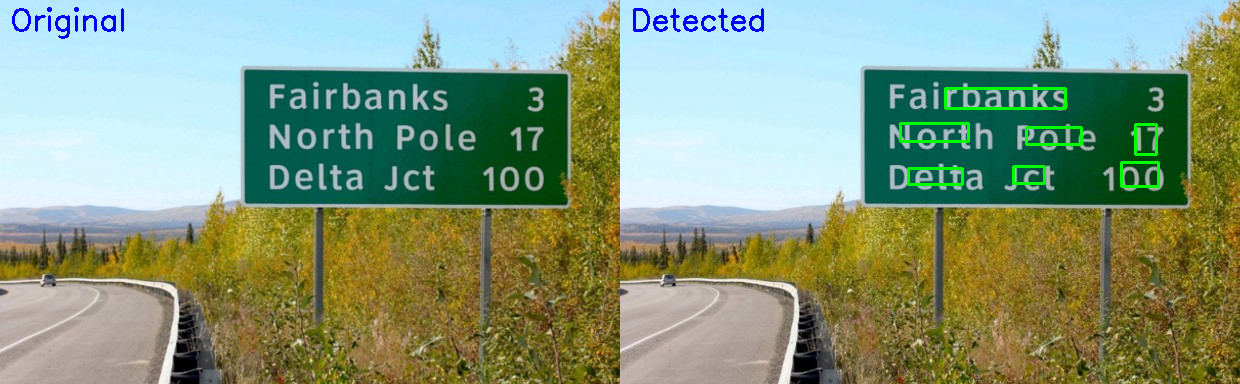

In [72]:
# Load the original image
original = cv2.imread("/content/Images/highway_sign.jpg")

# Process the image to detect text
detected_image = post_process(scores, geometry, rW, rH, original.copy())

# Combine and label the images for comparison
combine_and_label_images(original, detected_image)
